<a href="https://colab.research.google.com/github/NkosikhonaD/experiements/blob/master/TransfareContrastiveNylaBasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import random
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
from torch import optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
plt.ion()

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self,margin=2.0):
    super(ContrastiveLoss,self).__init__()
    self.margin = margin
    
  def forward(self,output1,output2,label):
    distance = F.pairwise_distance(output1,output2)
    loss_contrastive = torch.mean((1-label)*torch.pow(distance,2) + (label)*torch.pow(torch.clamp(self.margin-distance,min=0.0),2))
    return loss_contrastive

In [0]:
class SiameseNetworkDataset(Dataset):
  def __init__(self,imageFolderDataset,transform=None,should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.should_invert = should_invert
    self.transform=transform
  
  def __getitem__(self,index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    
    #randomise getting one class.
    should_get_same_class = random.randint(0,1)
    
    if should_get_same_class:
      while True:
        img1_tuple =random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] == img1_tuple[1]:
          break
    else:
      while True:
        img1_tuple =random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] != img1_tuple[1]:
          break
    
    img0 =Image.open(img0_tuple[0])
    img1 =Image.open(img1_tuple[0])
    
    #img0 = img0.convert("L")
    #img1 = img1.convert("L")
    
    if self.should_invert:
      img0 =PIL.ImageOps.invert(img0)
      img1 =PIL.ImageOps.invert(img1)
    if self.transform is not None:
      img0 = self.transform(img0)
      img1 = self.transform(img1)
      
    return img0, img1,torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
  
  def __len__(self):
    return len(self.imageFolderDataset.imgs)
    

In [0]:
!ls "/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/train"
print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is: ")
print(torch.backends.cudnn.version())

1    112  125  14   152  167  180  194	207  223  24   267  33	46  6	73  87
10   113  126  140  153  168  181  196	209  225  240  268  34	47  60	74  88
100  114  127  141  154  169  182  197	21   226  241  269  35	48  61	75  89
101  115  128  142  155  17   183  198	210  227  242  27   36	49  62	76  9
102  116  129  143  156  170  184  199	211  228  243  270  37	5   63	77  90
104  117  13   144  157  172  185  2	212  229  245  272  38	50  64	79  91
105  118  130  145  158  173  186  20	213  23   246  273  39	51  65	8   92
106  119  131  146  16	 174  187  200	215  230  247  274  4	52  67	80  93
107  12   132  147  160  175  188  201	217  231  25   28   40	53  68	81  94
108  120  134  148  161  176  189  202	218  232  250  29   41	54  69	82  95
109  121  135  149  162  177  19   203	219  233  251  3    42	55  7	83  96
11   122  136  15   164  178  190  204	22   234  252  30   43	56  70	84  97
110  123  137  150  165  179  191  205	220  237  26   31   44	57  71	85  98
111  124  139  151  

In [0]:
def imshow(img,text=None,should_save=False):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75, 8,text,style='italic',fontweight='bold',bbox={'facecolor':'white','alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
def show_plot(iteration,loss):
  plt.plot(iteration,loss)
  plt.show()
  
  

In [0]:
ls "/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/train"


1/    115/  130/  148/  165/  181/  199/  215/  233/  260/  35/  50/  68/  84/
10/   116/  131/  149/  166/  182/  2/    217/  234/  267/  36/  51/  69/  85/
100/  117/  132/  15/   167/  183/  20/   218/  237/  268/  37/  52/  7/   86/
101/  118/  134/  150/  168/  184/  200/  219/  239/  269/  38/  53/  70/  87/
102/  119/  135/  151/  169/  185/  201/  22/   24/   27/   39/  54/  71/  88/
104/  12/   136/  152/  17/   186/  202/  220/  240/  270/  4/   55/  72/  89/
105/  120/  137/  153/  170/  187/  203/  221/  241/  272/  40/  56/  73/  9/
106/  121/  139/  154/  172/  188/  204/  223/  242/  273/  41/  57/  74/  90/
107/  122/  14/   155/  173/  189/  205/  225/  243/  274/  42/  58/  75/  91/
108/  123/  140/  156/  174/  19/   206/  226/  245/  28/   43/  6/   76/  92/
109/  124/  141/  157/  175/  190/  207/  227/  246/  29/   44/  60/  77/  93/
11/   125/  142/  158/  176/  191/  209/  228/  247/  3/    45/  61/  79/  94/
110/  126/  143/  16/   177/  193/  21/   229/  25/  

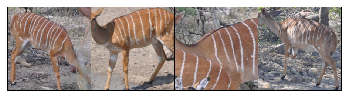

<built-in method numpy of Tensor object at 0x7f859ef7da68>


In [0]:
folder_dataset = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/train")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()]),should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=2,batch_size=2)
dataiter = iter(vis_dataloader)

example_batch=next(dataiter)
concatenated=torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 19.9MB/s]


Epoch number 0
 Current loss 17.154953002929688

Epoch number 0
 Current loss 1.0630457401275635

Epoch number 0
 Current loss 1.1368284225463867

Epoch number 1
 Current loss 1.1127986907958984

Epoch number 1
 Current loss 1.1354994773864746

Epoch number 1
 Current loss 1.011164903640747

Epoch number 2
 Current loss 0.9865988492965698

Epoch number 2
 Current loss 1.0701044797897339

Epoch number 2
 Current loss 1.1017587184906006

Epoch number 3
 Current loss 1.0592517852783203

Epoch number 3
 Current loss 1.2290575504302979

Epoch number 3
 Current loss 1.0921885967254639

Epoch number 4
 Current loss 1.0498170852661133

Epoch number 4
 Current loss 1.0676846504211426

Epoch number 4
 Current loss 1.083154320716858

Epoch number 5
 Current loss 1.0372250080108643

Epoch number 5
 Current loss 1.1220238208770752

Epoch number 5
 Current loss 1.089551329612732

Epoch number 6
 Current loss 1.0956612825393677

Epoch number 6
 Current loss 1.0268945693969727

Epoch number 6
 Current

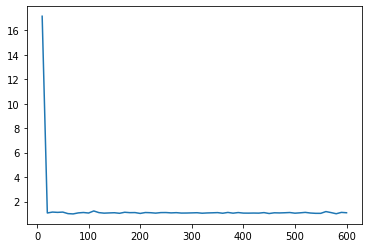

In [0]:
train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers =4,batch_size=64)

#net = SiameseNetwork().cuda()
#We are using the pretrained model fine tuninig .....  
model = models.resnet34(pretrained=True)

#using model as feature extraction 
# model = models.resnet34(pretrained=True)
#for param in model.parameters():
#  param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,128) 

model = model.cuda();

criterion = ContrastiveLoss()

optimizer = optim.Adam(model.parameters(),lr=0.0005)

counter = []

loss_history = []

iteration_number=0

for epoch in range(0,20):
  for i, data in enumerate(train_dataloader,0):
    img0,img1,label = data
    img0,img1,label=img0.cuda(),img1.cuda(),label.cuda()
    
    optimizer.zero_grad()
    #output1,output2 =net(img0,img1)
    output1 =model(img0)
    output2 = model(img1)

    loss_contrastive = criterion(output1,output2,label)
    
    loss_contrastive.backward()
    
    optimizer.step()
    if i%10 ==0:
      #print("Epoch number {}\n Current loss {} \n".format(epoch,loss_contrastive.item()))
      print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
      iteration_number +=10
      counter.append(iteration_number)
      #loss_history.append(loss_contrastive.item())
      loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)
    
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.38674911856651306 label 1.0


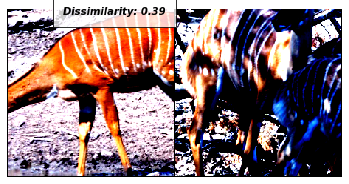

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.4577950239181519 label 1.0


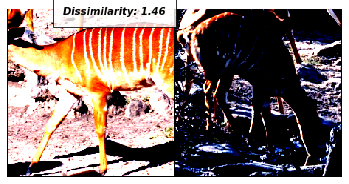

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4971887767314911 label 1.0


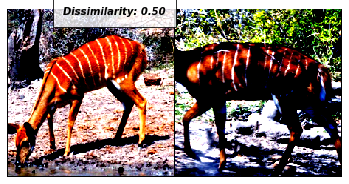

0.8072929382324219

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 label 1.0


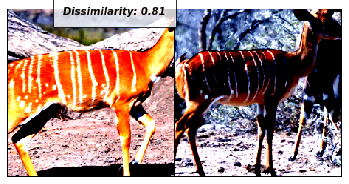

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.24222658574581146 label 1.0


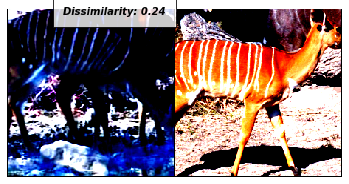

1.1313708455418237e-05 label 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


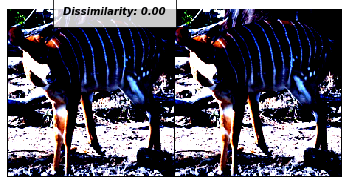

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5577061176300049 label 1.0


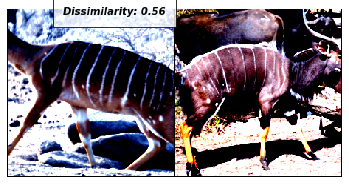

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.1313708455418237e-05 label 0.0


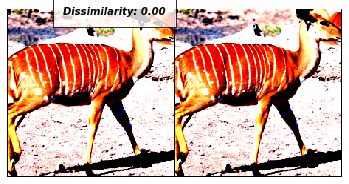

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5946897268295288 label 1.0


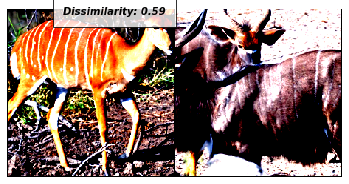

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.42682698369026184 label 1.0


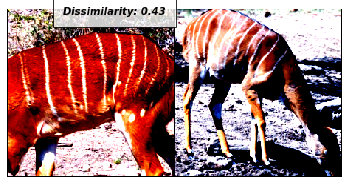

1.1313708455418237e-05 label 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


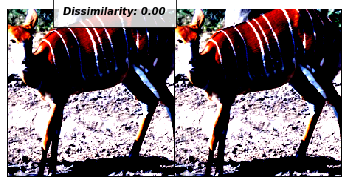

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.3675362169742584 label 1.0


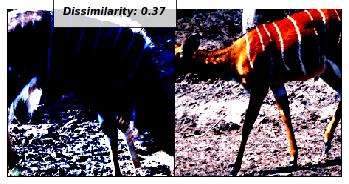

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.401100754737854 label 0.0


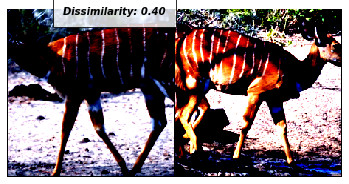

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.38758957386016846 label 1.0


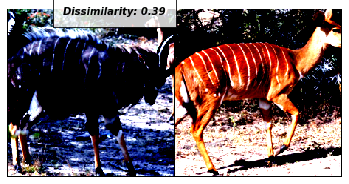

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.1313708455418237e-05 label 0.0


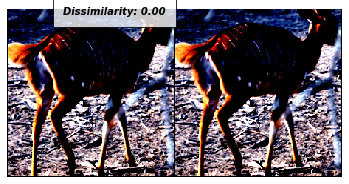

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6764401197433472 label 1.0


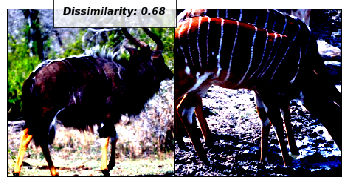

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4160814881324768 label 1.0


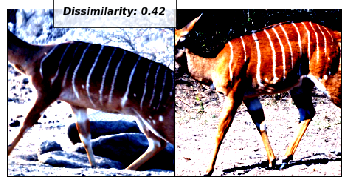

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7847027778625488 label 1.0


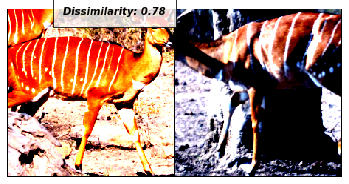

0.31345462799072266 label 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


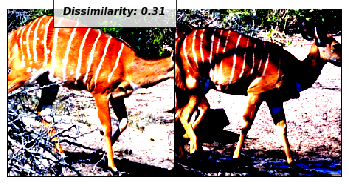

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.1313708455418237e-05 label 0.0


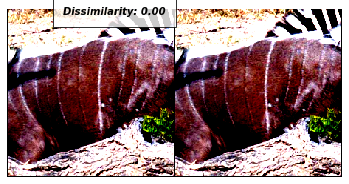

Accuracy of the network on test images is : 70 %
Acc  0.7  Recall  0.8333333333333334  Selectivity  0.6428571428571429  Precision  0.5 tot  20 total 20


In [20]:
folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/val")
siamese_dataset=SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
#x0,_,_= next(dataiter)
correct = 0
total =0
false_positive = 0
false_negative = 0
true_positive=0
true_negative = 0
  
for i in range(0,20):
  x0,x1,label2=next(dataiter)
  concatenated = torch.cat((x0,x1),0)
  output1 =model(Variable(x0).cuda())
  output2 = model(Variable(x1).cuda())
  distance = F.pairwise_distance(output1,output2)
  #distance = F.pairwise_distance(output1,output2)
  currDist = distance.cpu()
  print(currDist.item(),"label",label2.item())
  if(currDist.item()<0.4):
    if(label2.item()==0.0):
      correct+=1
      true_positive+=1
      total+=1
    else:
      false_positive+=1
      total+=1
  else:
    if(label2.item()==1):
      correct+=1
      true_negative+=1
      total+=1
    else:
      false_negative+=1
      total+=1 
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(distance.item()))
recall = true_positive/(true_positive+false_negative)

selectivity= true_negative/(true_negative+false_positive)

precision = true_positive/(true_positive+false_positive)
tot=(true_positive+true_negative+false_positive+false_negative)
Acc = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)

  
print("Accuracy of the network on test images is : %d %%" %(100*correct/total))
print("Acc ",Acc," Recall ",recall," Selectivity ",selectivity," Precision ",precision,"tot ",tot,"total",total)
  
  #print("MY {}".format(label1))
  #image_path = path_name.format(label2)+"/out_"+str(i)+".png"
  #torchvision.utils.save_image(x0,'/content/drive/My Drive/out.png')
  #torchvision.utils.save_image(x0,image_path)
  #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(distance.item()))
  
  
  